## 2. Preprocesar la imagen (recorte, normalización, extracción de características)

Modelo SVM y scaler (mejorados) cargados correctamente.


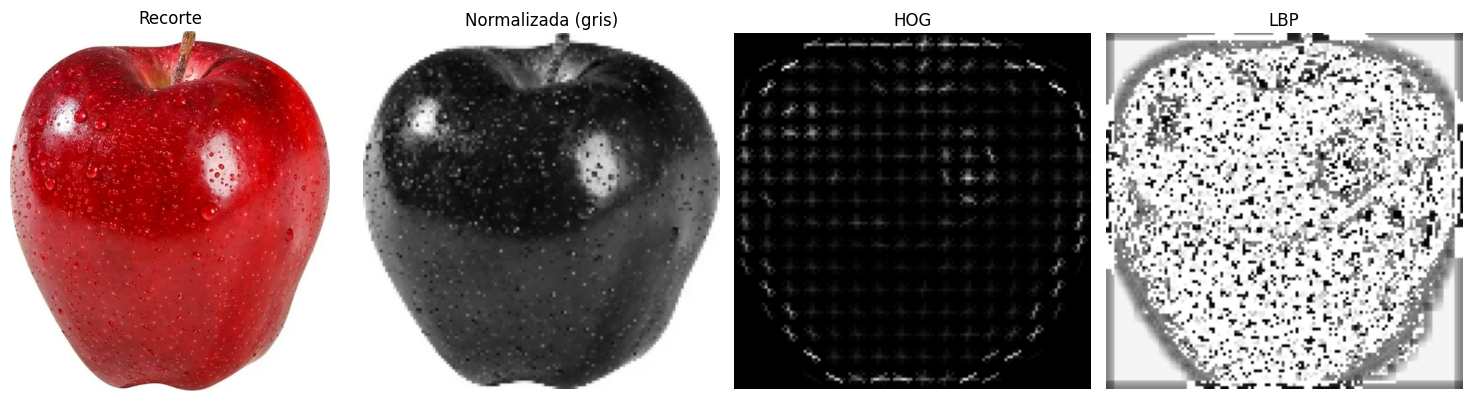

La fruta predicha es: Cocos 1

Top-3 predicciones:
Cocos 1: 0.68
Pear Forelle 1: 0.12
Kiwi 1: 0.08


In [50]:
import numpy as np
import cv2
from skimage.feature import hog, local_binary_pattern
import joblib
import matplotlib.pyplot as plt
import os

# --- Parámetros HOG y LBP ---
hog_orientations = 9
hog_pixels_per_cell = (8, 8)
hog_cells_per_block = (2, 2)
lbp_radius = 3
lbp_n_points = 8 * lbp_radius
lbp_method = 'uniform'
img_size = (128, 128)

# --- Cargar scaler y modelo SVM entrenados con RandomizedSearchCV ---
scaler_path = '/workspaces/fruit-detector-pricer/ProyectoFinal/SVM/models/scaler_hog_lbp_best.joblib'
svm_path = '/workspaces/fruit-detector-pricer/ProyectoFinal/SVM/models/svm_hog_lbp_best.joblib'

scaler = None
svm_model = None
try:
    scaler = joblib.load(scaler_path)
    svm_model = joblib.load(svm_path)
    print('Modelo SVM y scaler (mejorados) cargados correctamente.')
except Exception as e:
    print('Error al cargar el modelo o scaler:', e)

def preprocesar_y_predecir(img_path, visualizar=False):
    if not os.path.exists(img_path):
        raise FileNotFoundError(f'No se encontró la imagen: {img_path}')
    # 1. Leer imagen RGB
    img_rgb = cv2.imread(img_path)
    if img_rgb is None:
        raise ValueError(f'No se pudo leer la imagen: {img_path}')

    # 2. Segmentación (umbral simple para fondo blanco)
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(img_gray, 220, 255, cv2.THRESH_BINARY_INV)

    # 3. Morfología (apertura para limpiar ruido)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    mask_clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # 4. Recorte (bounding box de la fruta)
    coords = cv2.findNonZero(mask_clean)
    x, y, w, h = cv2.boundingRect(coords)
    img_crop = img_rgb[y:y+h, x:x+w]

    # 5. Normalización (resize)
    img_norm = cv2.resize(img_crop, img_size)

    # 6. Escala de grises
    img_final = cv2.cvtColor(img_norm, cv2.COLOR_BGR2GRAY)

    # 7. HOG
    hog_features, hog_image = hog(img_final,
                       orientations=hog_orientations,
                       pixels_per_cell=hog_pixels_per_cell,
                       cells_per_block=hog_cells_per_block,
                       visualize=True)

    # 8. LBP
    lbp = local_binary_pattern(img_final, P=lbp_n_points, R=lbp_radius, method=lbp_method)
    n_bins = int(lbp.max() + 1)
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)

    # 9. Concatenar características
    features = np.concatenate([hog_features, lbp_hist])

    if visualizar:
        plt.figure(figsize=(15,4))
        plt.subplot(1,4,1)
        plt.title('Recorte')
        plt.imshow(cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.subplot(1,4,2)
        plt.title('Normalizada (gris)')
        plt.imshow(img_final, cmap='gray')
        plt.axis('off')
        plt.subplot(1,4,3)
        plt.title('HOG')
        plt.imshow(hog_image, cmap='gray')
        plt.axis('off')
        plt.subplot(1,4,4)
        plt.title('LBP')
        plt.imshow(lbp, cmap='gray')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    # --- Predicción ---
    if scaler is not None and svm_model is not None:
        try:
            features = features.reshape(1, -1)
            features_scaled = scaler.transform(features)
            pred = svm_model.predict(features_scaled)
            print('La fruta predicha es:', pred[0])
            # Mostrar probabilidades top-3 si el modelo lo permite
            if hasattr(svm_model, 'predict_proba'):
                proba = svm_model.predict_proba(features_scaled)[0]
                clases = svm_model.classes_
                top3_idx = np.argsort(proba)[::-1][:3]
                print('\nTop-3 predicciones:')
                for idx in top3_idx:
                    print(f'{clases[idx]}: {proba[idx]:.2f}')
            return pred[0]
        except Exception as e:
            print('Error en la predicción:', e)
            return None
    else:
        print('No se pudo realizar la predicción por errores previos.')
        return None

# --- Ejecutar todo el pipeline ---
ruta_local = '/workspaces/fruit-detector-pricer/ProyectoFinal/SVM/manzanaa.jpg'  # Cambia por tu ruta
try:
    resultado = preprocesar_y_predecir(ruta_local, visualizar=True)
except Exception as e:
    print('Error en el pipeline:', e)
    resultado = None